In [1]:
import os
from os import listdir
import math

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torch.utils.data
print(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

cuda


In [15]:
### before start , please check image_table.csv
### Ref: https://chih-sheng-huang821.medium.com/03-pytorch-dataaug-a712a7a7f55e

# output [1] same shape
class MyDataset01(torch.utils.data.Dataset):
    def __init__(self, root, tab_file = 'basic_image_tab.csv', transform = None, train = True, scale = 0.8, 
                 IsAug = None, shape = (64, 64), pad_module = ['center', 'center'], test=False):
        super().__init__()
        '''
        parameter:
            root : .csv file root
            tab_file : image info. on csv
            transform : if not None , maybe using 
            train : using training set or validation set
            scale : numble of training set on dataset
            IsAug : Using Augumentation Data , only train == True
            shape : change Image size for what
            pad_module: padding direction , ex: set 'Center' padding/change size around image
            
            
            padding module used cut height if resize h < ground truth h ex: resize_h = 64 , 
            gt_h = 64 ,cut where? top or bottom, input [h_direction, w_direction] ,ex:[center, left]
        '''
        df = pd.read_csv(root + '/'+ tab_file , encoding = 'big5')
        imgs = df['img_name'].values.tolist()
        labels = df['img_token'].values.tolist()
        
        self.imgs = imgs
        self.labels = labels
        
        self.root = os.path.join(root, 'ImageDataset', 'training_set')
        if test != False:
            self.root = os.path.join(root, 'ImageDataset', 'testing_set', test)
        self.train = train
        self.transform = transform
        self.IsAug = IsAug
        self.height, self.width = shape
        self.pad_module = pad_module
        
        self.count = int(len(self.imgs)*scale)
    def __len__(self):
        if self.train == True:
            return self.count
        else :
            return len(self.imgs) - self.count
            
    
    def __getitem__(self, index):
        
        if self.IsAug != None :
            # only augumentation training_data
            if self.train == True:
                transform_toResize = torchvision.transforms.Resize((self.height, self.width))
                img_path = os.path.join(self.root , self.imgs[index])
                img = Image.open(img_path)
                img = transform_toResize(img)
                
                label = self.labels[index]
                
                if self.IsAug == 'Rotate90':
                    img = img.transpose(Image.ROTATE_90)
                elif self.IsAug == 'Rotate180':
                    img = img.transpose(Image.ROTATE_180)
                elif self.IsAug == 'Rotate270':
                    img = img.transpose(Image.ROTATE_270)
                elif self.IsAug == 'Rotate_pos_20':
                    img = img.rotate(-20) #順時
                elif self.IsAug == 'Rotate_neg_20':
                        img = img.rotate(20)
                else:
                    raise ValueError('>>If want to using Aug_Data, follow specified param. or new one')
            
                trans_toTensor = torchvision.transforms.ToTensor()
                img = trans_toTensor(img)
                
                return img, label
            else:
                raise ValueError('>>Get Dataset Error : If used Augumentation data, please check \'train=True\'. ')
        # ============
        else:
            
            if self.train == True:
                img_path = os.path.join(self.root , self.imgs[index])
                img = Image.open(img_path)
                label = self.labels[index]
            else:
                img_path = os.path.join(self.root , self.imgs[self.count+index])
                img = Image.open(img_path)
                label = self.labels[self.count+index]
                
            gt_height , gt_width = np.array(img).shape[0], np.array(img).shape[1] # ground truth
            
            if gt_width > self.width:
                transform_toResize = torchvision.transforms.Resize((self.height, self.width))
                img = transform_toResize(img)
            else:
                add_h = self.height - gt_height
                add_w = self.width - gt_width
                
                # padding = (add_left, add_top, add_right, add_bottom)
                if self.pad_module[0] == 'center':
                    if add_h % 2 == 0:
                        add_top = add_h//2
                        add_bottom = add_h//2
                    else:
                        add_top = add_h//2
                        add_bottom = add_h//2 + 1
                elif self.pad_module[0] == 'top':
                    add_top = add_h
                else:
                    add_bottom = add_h
                    
                if self.pad_module[1] == 'center':
                    if add_w % 2 == 0:
                        add_left = add_w//2
                        add_right = add_w//2
                    else:
                        add_left = add_w//2
                        add_right = add_w//2+1
                elif self.pad_module[1] == 'left':
                    add_left = add_w
                else:
                    add_right = add_w
                    
                padding = (add_left, add_top, add_right, add_bottom)
                trans_pad = torchvision.transforms.Pad(padding, fill = 0, padding_mode="constant")
                img = trans_pad(img)
            trans_toTensor = torchvision.transforms.ToTensor()
            img = trans_toTensor(img)
            
            return img, label
        
if __name__ == '__main__':
    
    root = os.getcwd()

    train_data = MyDataset01(root)
    print('train_data :', len(train_data))
    valid_data = MyDataset01(root, train = False)
    print('valid_data :', len(valid_data))
    test_data = MyDataset01(root, tab_file = 'test_image0615_tab.csv', scale = 1, test = 'test_stage_data_0615')
    print('test_data :', len(test_data))
    test_data = MyDataset01(root, tab_file = 'test_image0616_tab.csv', scale = 1, test = 'test_stage_data_0616')
    print('test_data :', len(test_data))

train_data : 55043
valid_data : 13761
test_data : 2000
test_data : 7016


55043
7016


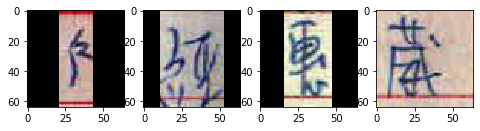

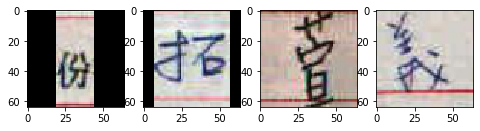

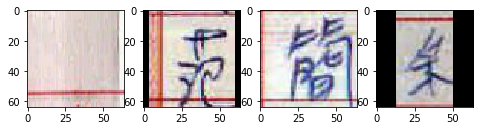

In [2]:
# output [2] different shape
class MyDataset02(torch.utils.data.Dataset):
    def __init__(self, root, tab_file = 'basic_image_tab.csv', transforms = None, train = True, scale = 0.8, test=False):
        super().__init__()
        '''
        
        '''
        df = pd.read_csv(root + '/'+ tab_file , encoding = 'big5')
        img_lst = df['img_name'].values.tolist()
        label_lst = df['img_token'].values.tolist()
        
        self.root = os.path.join(root, 'ImageDataset', 'training_set')
        if test != False:
            self.root = os.path.join(root, 'ImageDataset', 'testing_set', test)
        self.transforms = transforms
        self.train = train
        
        self.imgs = img_lst
        self.labels = label_lst
        self.count = int(len(self.imgs)*scale)
        
        
    def __len__(self):
        if self.train == True:
            return self.count
        else :
            return len(self.imgs) - self.count
        
    def __getitem__(self, index):
        
        if self.train == True:
            img_path = os.path.join(self.root , self.imgs[index])
            img = Image.open(img_path)
            label = self.labels[index]
        else:
            img_path = os.path.join(self.root , self.imgs[self.count+index])
            img = Image.open(img_path)
            label = self.labels[self.count+index]
            
        if self.transforms != None:
            img = self.transforms(img)
            
        return img, label
    # !!!!!!!!!!!!!!!!!! 透過自定義(custom)方式做batch
    @staticmethod
    def collate_fn(batch):
        return tuple(zip(*batch))

def Batch_Image_Data(data, resize_shape = (64, 64)):
    
    for index in range(len(data)):
        img = data[index].unsqueeze(0) # b, c, h, w == [1, 3, h, w]
        scale_f = resize_shape[0]/(img.size()[2])
        
        if resize_shape[1] > img.size()[3]:
            if img.size()[3] * scale_f < 1:
                resize_data = nn.functional.interpolate(img, resize_shape, mode = 'bilinear', align_corners=True)
            else:
                img = nn.functional.interpolate(img, scale_factor = scale_f, mode = 'bilinear', align_corners=True)
                scale_width = img.size()[3]
                pad_width = resize_shape[1] - scale_width
                if pad_width % 2 ==0:
                    padding = (pad_width//2, 0, pad_width//2, 0)# left, top, right, botton
                else:
                    padding = (pad_width//2, 0, pad_width//2+1, 0)# left, top, right, botton

                data_transforms_pad = torchvision.transforms.Compose([
                    torchvision.transforms.Pad(padding, fill = 0, padding_mode="constant"),
                    torchvision.transforms.ToTensor()
                ])
                data_transforms_toImage = torchvision.transforms.ToPILImage()
                scale_image = data_transforms_toImage(img.squeeze(0))
                resize_data = data_transforms_pad(scale_image).unsqueeze(0)
            
        else:
            resize_data = nn.functional.interpolate(img, resize_shape, mode = 'bilinear', align_corners=True) 
        if index == 0 :
            out = resize_data
        else:
            out = torch.cat([out, resize_data], dim = 0)
            
    return out
    

if __name__ == '__main__':
    data_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    train_data_set = MyDataset02(root = os.getcwd(), transforms = data_transform)
    test_data_set = MyDataset02(root = os.getcwd(), transforms = data_transform, 
                                tab_file = 'test_image0616_tab.csv', scale = 1, test = 'test_stage_data_0616')
    print(len(train_data_set))
    print(len(test_data_set))
    data_loader = torch.utils.data.DataLoader(dataset = train_data_set,
                                             batch_size = 4,
                                             shuffle = False,
                                             collate_fn = train_data_set.collate_fn) 
    for i, (data, label) in enumerate(data_loader):
        data = Batch_Image_Data(data)
        index = 0
        plt.figure(figsize =(8,4))
        for sample in data:
            
            plt.subplot(1, 4, index+1)
            plt.imshow(torchvision.transforms.ToPILImage()(sample))
            index += 1
        if i == 2:
            break    

In [3]:
# get model
# weight Standardization Conv.
# ref: https://github.com/joe-siyuan-qiao/WeightStandardization
class WS_Conv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1,
                padding = 0, dilation =1, groups =1, bias = True):
        
        super(WS_Conv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
                                       padding, dilation, groups, bias)
        
    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1,keepdim = True).mean(dim = 2, keepdim = True).mean(dim = 3, keepdim = True)
        weight = weight - weight_mean
        
        std = weight.view(weight.size(0), -1).std(dim = 1).view(-1, 1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return torch.nn.functional.conv2d(x, weight, self.bias, self.stride, self.padding,
                        self.dilation, self.groups)
    
    

class Base_block_GN(nn.Module):
    def __init__(self, in_planes, planes, stride = 1, GN_num = 32):
        super(Base_block_GN, self).__init__()

        self.stride = stride
        self.conv = nn.Sequential(
            WS_Conv2d(in_planes, planes, kernel_size=(3, 3), stride = self.stride, padding = 1),
            nn.GroupNorm(GN_num, planes),
            nn.ReLU(),
            WS_Conv2d(planes, planes, kernel_size=(3, 3), stride = 1, padding=1),
            nn.GroupNorm(GN_num, planes)
        )

        self.shortcut = nn.Sequential()
        if self.stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                WS_Conv2d(in_planes, planes, kernel_size=1, stride=self.stride),
                nn.GroupNorm(GN_num, planes)
            )
        self.activate_out = nn.ReLU()
    def forward(self, x):
        out = self.conv(x)
        out += self.shortcut(x)
        out = self.activate_out(out)

        return out
class base_ResNet(nn.Module):
    def __init__(self, block, n_block=[2,2,2,2], in_planes = 64,n_class = 801, n_gn = 32, last_layer = 'softmax'):
        super(base_ResNet, self).__init__()
        
        self.planes = in_planes
        
        self.conv = nn.Sequential(
            WS_Conv2d(3, self.planes, kernel_size = 3, stride = 1, padding = 1),
            nn.GroupNorm(n_gn, self.planes),
            nn.ReLU()
        )
        
        self.layer1 = self._make_layer(block, in_planes, n_block[0], stride = 1, GN_num = n_gn)
        self.layer2 = self._make_layer(block, in_planes*2, n_block[1], stride = 2, GN_num = n_gn)
        self.layer3 = self._make_layer(block, in_planes*4, n_block[1], stride = 2, GN_num = n_gn)
        self.layer4 = self._make_layer(block, in_planes*8, n_block[1], stride = 2, GN_num = n_gn)
        
        self.fc = nn.Linear(in_planes*8, n_class)
        self.softmax = nn.Sequential()
        if last_layer == 'softmax':
            self.softmax = nn.Softmax(dim = -1)
        elif last_layer == 'Logsoftmax':
            self.softmax = nn.LogSoftmax(dim = -1)
    
    def _make_layer(self, block, out_planes, n_blocks, stride, GN_num):
        strides = [stride] + [1] * (n_blocks-1) # ex: block = 2, strides = [2, 1] ; block = 3, strides = [2, 1, 1]
        layers = []
        for stride in strides:
            layers.append(block(self.planes, out_planes, stride, GN_num))
            self.planes = out_planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        out = self.conv(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = torch.nn.functional.avg_pool2d(out, out.size(2))
        out = out.view(out.size(0), -1)
        
        out = self.fc(out)
        out = self.softmax(out)
        
        return out
if __name__ == '__main__':
    input_x = torch.randn(5, 3, 64, 64)
    model = base_ResNet(Base_block_GN)
    pred_out = model(input_x)
    print(pred_out.size())
    
    model = base_ResNet(Base_block_GN, last_layer = 'Logsoftmax')
    pred_out = model(input_x)
    print(pred_out.size())
    
    # 計算參數量 ,calculate parameters num
    
    
    Total_params = 0
    Trainable_params = 0
    NonTrainable_params = 0
    for param in model.parameters():
        mulValue = np.prod(param.size())  # 使用numpy prod 計算參數所有元素之積
        Total_params += mulValue  # 總參數量
        if param.requires_grad:
            Trainable_params += mulValue  # 可訓練參數量
        else:
            NonTrainable_params += mulValue  # 非可訓練參數量

    print(f'Total params: {Total_params}')
    print(f'Trainable params: {Trainable_params}')
    print(f'Non-trainable params: {NonTrainable_params}')

torch.Size([5, 801])
torch.Size([5, 801])
Total params: 11584545
Trainable params: 11584545
Non-trainable params: 0


In [10]:
# get Acc. when every EPOCK training, and then using 'batch' data
def Get_Pred_Acc_with_Train(model, data, count):
    with torch.no_grad():
        correct = 0
        IsGpu = False

        if torch.cuda.is_available() and str(next(model.parameters()).device) !='cpu':
            IsGpu = True
            
        for i ,(img, label) in enumerate(data):
            if IsGpu == True:
                img = img.cuda()
            pred = model(img)
            pred_value, pred_label = torch.max(pred, 1)
            
            if IsGpu == False:
                pred = pred_label.data.numpy()
            else:
                pred = pred_label.data.cpu().numpy()
            
            correct += (pred == label.data.numpy()).sum()  
        acc = 100*correct/count
        return acc
if __name__ == '__main__':
    print('get')
#     torch.cuda.empty_cache()
#     model = base_ResNet(Base_block_GN)
#     if torch.cuda.is_available():
#         model = model.cuda()
#     test_data = MyDataset01(root, tab_file = 'test_image0615_tab.csv', scale = 1, test = 'test_stage_data_0615')
#     test_dataloader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 32, shuffle = False)
#     acc = Get_Pred_Acc_with_Train(model, test_dataloader, len(test_data))

get


In [ ]:
''' train & valid '''
torch.cuda.empty_cache() # clean cache, use jupyter note have some cache on gpu memory after training
# get data
root = os.getcwd()
train_data_set = MyDataset01(root)
valid_data_set = MyDataset01(root, train=False)

train_data_loader = torch.utils.data.DataLoader(dataset = train_data_set, batch_size = 16, shuffle = True)
valid_data_loader = torch.utils.data.DataLoader(dataset = valid_data_set, batch_size = 32, shuffle = True)

# 
test_data = MyDataset01(root, tab_file = 'test_image0616_tab.csv', scale = 1, test = 'test_stage_data_0616')
test_dataloader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 32, shuffle = False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH = 30
LR = 0.001
loss_CE = nn.CrossEntropyLoss()
model_01 = base_ResNet(Base_block_GN) # with softmax 
model_02 = base_ResNet(Base_block_GN, last_layer = 'Logsoftmax') # with logsoftmax

optimizer_01 = torch.optim.Adam(model_01.parameters(), lr = LR)
optimizer_02 = torch.optim.Adam(model_02.parameters(), lr = LR)
if torch.cuda.is_available():
    model_01 = model_01.to(device)
    model_02 = model_02.to(device)

train_loss_01, valid_loss_01 , record_acc_01 = [], [], []
train_loss_02, valid_loss_02 , record_acc_02 = [], [], []

index = 0

for epoch in range(EPOCH):
    for i , (data, label) in enumerate(train_data_loader):
        
        optimizer_01.zero_grad()
        optimizer_02.zero_grad()
        
        if torch.cuda.is_available():
            data = data.to(device)
            label = label.to(device)
        
        #
        out_01 = model_01(data)
        t_loss_01 = loss_CE(out_01, label)
        t_loss_01.backward()
        optimizer_01.step()
        
        out_02 = model_02(data)
        t_loss_02 = loss_CE(out_02, label)
        t_loss_02.backward()
        optimizer_02.step()

        if index % 200 == 0:
            # ===== get valid loss =====
            with torch.no_grad():
                # randn get valid data to record loss
                for i , (data, label) in enumerate(valid_data_loader):
                    if torch.cuda.is_available():
                        data = data.to(device)
                        label = label.to(device)
                        
                    out_01 = model_01(data)
                    v_loss_01 = loss_CE(out_01, label)
                    out_02 = model_02(data)
                    v_loss_02 = loss_CE(out_02, label)
                    break
            # ===== record loss =====
            train_loss_01.append(t_loss_01.item())
            valid_loss_01.append(v_loss_01.item())
            
            train_loss_02.append(t_loss_02.item())
            valid_loss_02.append(v_loss_02.item())
            
        index += 1
    with torch.no_grad():
        print('epoch[{}], train_loss:{:.5f}, valid_loss:{:.5f}, '.format(epoch+1, 
                                        t_loss_01.item(), v_loss_01.item()))
        acc01 = Get_Pred_Acc_with_Train(model_01, test_dataloader, len(test_data))
        record_acc_01.append(acc01)
        print('softmax Accurcy :', acc01)
        
        print('epoch[{}], train_loss:{:.5f}, valid_loss:{:.5f}, '.format(epoch+1, 
                                        t_loss_02.item(), v_loss_02.item()))
        acc02 = Get_Pred_Acc_with_Train(model_02, test_dataloader, len(test_data))
        record_acc_02.append(acc02)
        print('logsoftmax Accurcy :', acc02)
# clean cache
torch.cuda.empty_cache()
# result : softmax couldn't training 
# GPU menory is small ,u can see the training result with 'baseline_with_Resnet_colab'
# 使用softmax無法被訓練，其結果如下，另外有使用colab做訓練 供參考證明

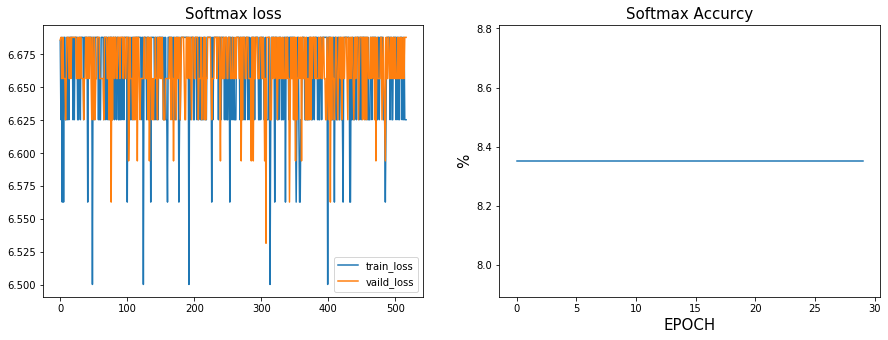

In [16]:
# logsoftmax result
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_01, label = 'train_loss')
plt.plot(valid_loss_01, label = 'vaild_loss')
plt.title('Softmax loss',size = 15)
plt.legend(fontsize = 10)
plt.subplot(1, 2, 2)
plt.plot(record_acc_01)
plt.title('Softmax Accurcy', size = 15)
plt.ylabel('%', size = 15)
plt.xlabel('EPOCH', size = 15)
print()

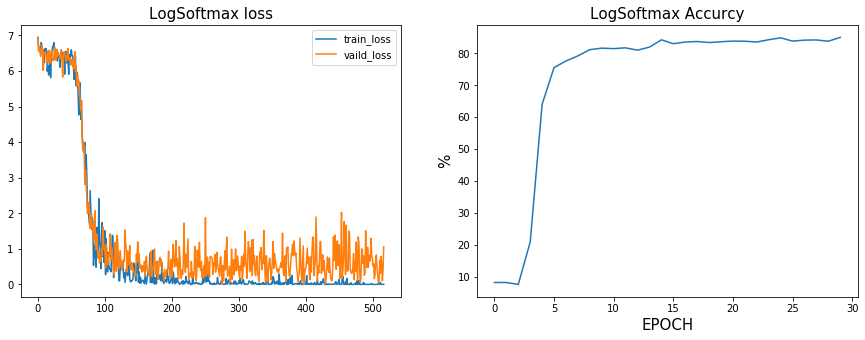

In [14]:
# logsoftmax result
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_02, label = 'train_loss')
plt.plot(valid_loss_02, label = 'vaild_loss')
plt.title('LogSoftmax loss',size = 15)
plt.legend(fontsize = 10)
plt.subplot(1, 2, 2)
plt.plot(record_acc_02)
plt.title('LogSoftmax Accurcy', size = 15)
plt.ylabel('%', size = 15)
plt.xlabel('EPOCH', size = 15)
print()

In [ ]:
# pred test, only show competition one day data , because the dataset is private
# 只提供某一天的比賽數據當做model參數的預測證明

In [4]:
def Get_Pred_Acc_with_Train_02(model, data, count, shape = (64, 64)):
    with torch.no_grad():
        correct = 0
        IsGpu = False

        if torch.cuda.is_available() and str(next(model.parameters()).device) !='cpu':
            IsGpu = True
            
        for i ,(img, label) in enumerate(data):
            img = Batch_Image_Data(img, resize_shape = shape)
            # label == list 
            if IsGpu == True:
                img = img.cuda()
            pred = model(img)
            pred_value, pred_label = torch.max(pred, 1)
            
            if IsGpu == False:
                pred = pred_label.data.numpy()
            else:
                pred = pred_label.data.cpu().numpy()

            correct += (pred == np.array(label)).sum()  
            
        acc = 100*correct/count
        return acc
if __name__ == '__main__':
    print('get')
    # sample
#     test_data_set03 = MyDataset02(root = os.getcwd(), transforms = data_transform, 
#                                 tab_file = 'test_image0616_tab.csv', scale = 1, test = 'test_stage_data_0616')
#     test_data_loader03 = torch.utils.data.DataLoader(dataset = test_data_set03, batch_size = 64, 
#                                                  shuffle = False, collate_fn = train_data_set.collate_fn) ##
#     model_03 = base_ResNet(Base_block_GN, last_layer = 'Logsoftmax')
#     acc = Get_Pred_Acc_with_Train_02(model_03, test_data_loader03, len(test_data_set03))
#     print(acc)

get


train_data_Resize : 55043


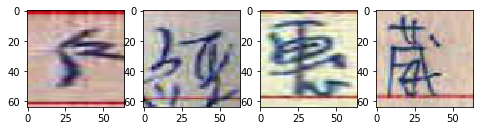

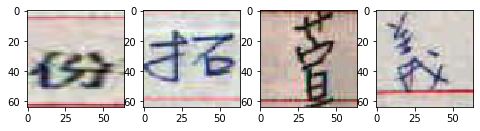

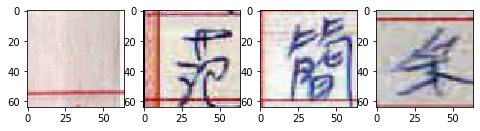

In [13]:
class Dataset_Resize(torch.utils.data.Dataset):
    def __init__(self, root,tab_file = 'basic_image_tab.csv', transforms = None, train = True,
                 scale = 0.8, shape = (64, 64), test = False):
        super().__init__()
        
        df = pd.read_csv(root + '/'+ tab_file , encoding = 'big5')
        imgs = df['img_name'].values.tolist()
        labels = df['img_token'].values.tolist()
        self.imgs = imgs
        self.labels = labels
        
        self.root = os.path.join(root, 'ImageDataset', 'training_set')
        if test != False:
            self.root = os.path.join(root, 'ImageDataset', 'testing_set', test)
        self.train = train
        self.transforms = transforms
        self.count = int(len(self.imgs)*scale)
        self.shape = shape
        
        
    def __len__(self):
        if self.train == True:
            return self.count
        else :
            return len(self.imgs) - self.count
        
    def __getitem__(self, index):
        
        
        if self.train == True:
            img_path = os.path.join(self.root , self.imgs[index])
            img = Image.open(img_path)
            label = self.labels[index]
        else:
            img_path = os.path.join(self.root , self.imgs[self.count+index])
            img = Image.open(img_path)
            label = self.labels[self.count+index]
            
        if self.transforms != None:
            img = self.transforms(img)
        else:
            transform_data = torchvision.transforms.Compose([
                torchvision.transforms.Resize((self.shape)),
                torchvision.transforms.ToTensor()
            ])
            img = transform_data(img)
        return img, label
if __name__ == '__main__':
    
    root = os.getcwd()
    train_data_Resize = Dataset_Resize(root)
    print('train_data_Resize :', len(train_data_Resize))
    data_loader = torch.utils.data.DataLoader(dataset = train_data_Resize, batch_size = 4,shuffle = False)
    
    for i, (data, label) in enumerate(data_loader):

        index = 0
        plt.figure(figsize =(8,4))
        for sample in data:
            
            plt.subplot(1, 4, index+1)
            plt.imshow(torchvision.transforms.ToPILImage()(sample))
            index += 1
        if i == 2:
            break    

In [18]:
''' train & valid '''
torch.cuda.empty_cache() # clean cache, use jupyter note have some cache on gpu memory after training
# get data
SHAPE = (64,64)
root = os.getcwd()
# Padding Data
# train_data_set_pad = MyDataset01(root, shape = SHAPE)
# valid_data_set_pad = MyDataset01(root, shape = SHAPE, train=False)

# train_data_loader_pad = torch.utils.data.DataLoader(dataset = train_data_set_pad, batch_size = 16, shuffle = True)
# valid_data_loader_pad = torch.utils.data.DataLoader(dataset = valid_data_set_pad, batch_size = 32, shuffle = True)
 
# test_data_pad = MyDataset01(root, tab_file = 'test_image0616_tab.csv', scale = 1, test = 'test_stage_data_0616')
# test_dataloader_pad = torch.utils.data.DataLoader(dataset = test_data_pad, batch_size = 32, shuffle = False)
# Resize Data
train_data_set_resize = Dataset_Resize(root, shape = SHAPE)
valid_data_set_resize = Dataset_Resize(root, shape = SHAPE, train=False)

train_data_loader_resize = torch.utils.data.DataLoader(dataset = train_data_set_resize, batch_size = 16, shuffle = True)
valid_data_loader_resize = torch.utils.data.DataLoader(dataset = valid_data_set_resize, batch_size = 32, shuffle = True)
 
test_data_resize = Dataset_Resize(root, tab_file = 'test_image0616_tab.csv', scale = 1, test = 'test_stage_data_0616')
test_dataloader_resize = torch.utils.data.DataLoader(dataset = test_data_resize, batch_size = 32, shuffle = False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH = 30
LR = 0.001
loss_CE = nn.CrossEntropyLoss()
# model_Pad = base_ResNet(Base_block_GN, last_layer = 'Logsoftmax')
model_Resize = base_ResNet(Base_block_GN, last_layer = 'Logsoftmax')

# optimizer_Pad = torch.optim.Adam(model_Pad.parameters(), lr = LR)
optimizer_Resize = torch.optim.Adam(model_Resize.parameters(), lr = LR)
if torch.cuda.is_available():
    model_Resize = model_Resize.to(device)
#     model_Pad = model_Pad.to(device)
    

# train_loss_Pad, valid_loss_Pad , record_acc_Pad = [], [], []
train_loss_Resize, valid_loss_Resize , record_acc_Resize = [], [], []

# index_pad = 0
index_resiez = 0
for epoch in range(EPOCH):
    # train Padding dataset
#     for i, (data, label) in enumerate(train_data_loader_pad):
#         optimizer_Pad.zero_grad()

#         if torch.cuda.is_available():
#             data = data.to(device)
#             label = label.to(device)
#         #
#         out_pad = model_Pad(data)
#         t_loss_pad = loss_CE(out_pad, label)
#         t_loss_pad.backward()
#         optimizer_Pad.step()
#         if index_pad % 200 == 0:
#             # ===== get valid loss =====
#             with torch.no_grad():
#                 # randn get valid data to record loss
#                 for i , (data, label) in enumerate(valid_data_loader_resize):
                    
#                     if torch.cuda.is_available():
#                         data = data.to(device)
#                         label = label.to(device)
                        
#                     out_pad = model_Pad(data)
#                     v_loss_pad = loss_CE(out_pad, label)
#                     break
#             # ===== record loss =====
#             train_loss_Pad.append(t_loss_pad.item())
#             valid_loss_Pad.append(v_loss_pad.item())
#         index_pad += 1
        
    # train Resize dataset
    for i, (data, label) in enumerate(train_data_loader_resize):
        optimizer_Resize.zero_grad()
        if torch.cuda.is_available():
            data = data.to(device)
            label = label.to(device)
            
        out_resize = model_Resize(data)
        t_loss_resize = loss_CE(out_resize, label)
        t_loss_resize.backward()
        optimizer_Resize.step()
        if index_resize % 200 == 0:
            # ===== get valid loss =====
            with torch.no_grad():
                # randn get valid data to record loss
                for i , (data, label) in enumerate(valid_data_loader_resize):
                    if torch.cuda.is_available():
                        data = data.to(device)
                        label = label.to(device)
                    out_resize = model_Resize(data)
                    v_loss_resize = loss_CE(out_resize, label)
                    break
                # ===== record loss =====
            train_loss_Resize.append(t_loss_risize.item())
            valid_loss_Resize.append(v_loss_risize.item())
        index_resize += 1
        
    with torch.no_grad():
        print('epoch [{}]'.format(epoch+1))
#         acc_pad = Get_Pred_Acc_with_Train(model_Pad, test_dataloader_pad, len(test_data_pad))
        acc_resize = Get_Pred_Acc_with_Train(model_Resize, test_dataloader_resize, len(test_data_resize))
#         print('Padding : train_loss:{:.5f}, valid_loss:{:.5f}, Acc:{:.5f}'.format(t_loss_pad.item(),
#                                                                                   v_loss_pad.item(),
#                                                                                   acc_pad))
        print('Resize  : train_loss:{:.5f}, valid_loss:{:.5f}, Acc:{:.5f} '.format(t_loss_resize.item(),
                                                                                  v_loss_resize.item(),
                                                                                  acc_resize))
        record_acc_Pad.append(acc_pad)
        record_acc_Resize.append(acc_resize)
        print('======\n')
    
# padding data == model02 , so don't train again , the result 'baseline_with_Resnet_colab'

In [1]:
# === Padding VS Interpolate 96x96 ===
torch.cuda.empty_cache()
SHAPE = (96, 96)
root = os.getcwd()
# Padding data
# train_data_set_pad = MyDataset01(root, shape = SHAPE)
# valid_data_set_pad = MyDataset01(root, shape = SHAPE, train=False)

# train_data_loader_pad = torch.utils.data.DataLoader(dataset = train_data_set_pad, batch_size = 16, shuffle = True)
# valid_data_loader_pad = torch.utils.data.DataLoader(dataset = valid_data_set_pad, batch_size = 32, shuffle = True)
 
# test_data_pad = MyDataset01(root, tab_file = 'test_image0616_tab.csv', shape = SHAPE, 
#                             scale = 1, test = 'test_stage_data_0616')
# test_dataloader_pad = torch.utils.data.DataLoader(dataset = test_data_pad, batch_size = 32, shuffle = False)

# Interpolate data
data_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_data_set_interpolate = MyDataset02(root = os.getcwd(), transforms = data_transform)
valid_data_set_interpolate = MyDataset02(root = os.getcwd(), transforms = data_transform, train=False) 

train_data_loader_interpolate = torch.utils.data.DataLoader(dataset = train_data_set_interpolate, 
                                    batch_size = 4, shuffle = True,collate_fn = train_data_set.collate_fn)
valid_data_loader_interpolate = torch.utils.data.DataLoader(dataset = valid_data_set_interpolate, 
                                    batch_size = 32, shuffle = True,collate_fn = train_data_set.collate_fn)

test_data_set_interpolate = MyDataset02(root = os.getcwd(), transforms = data_transform, 
                                tab_file = 'test_image0616_tab.csv', scale = 1, test = 'test_stage_data_0616')
test_data_loader_interpolate = torch.utils.data.DataLoader(dataset = test_data_set_interpolate, batch_size = 32, 
                                                 shuffle = False, collate_fn = train_data_set.collate_fn) 

# get model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH = 30
LR = 0.001
loss_CE = nn.CrossEntropyLoss()
model_pad = base_ResNet(Base_block_GN, last_layer = 'Logsoftmax')
optim_pad = torch.optim.Adam(model_pad.parameters(), lr = LR)
model_interpolate = base_ResNet(Base_block_GN, last_layer = 'Logsoftmax')
optim_interpolate = torch.optim.Adam(model_interpolate.parameters(), lr = LR)

if torch.cuda.is_available():
    model_pad = model_pad.to(device)
    model_interpolate = model_interpolate.to(device)
    
train_loss_pad, valid_loss_pad , record_acc_pad = [], [], []
index_pad = 0
train_loss_interpolate, valid_loss_interpolate , record_acc_interpolate = [], [], []
index_interpolate = 0

# training & testing
for epoch in range(EPOCH):
    # Padding Data
#     for i, (data, label) in enumerate(train_data_loader_pad):
#         optim_pad.zero_grad()
#         if torch.cuda.is_available():
#             data = data.to(device)
#             label = label.to(device)
#         out_pad = model_pad(data)
#         t_loss_pad = loss_CE(out_pad, label)
#         t_loss_pad.backward()
#         optim_pad.step()
#         if index_pad % 200 == 0:
#             for i ,(data, label) in enumerate(valid_data_loader_pad):
#                 if torch.cuda.is_available():
#                     data = data.to(device)
#                     label = label.to(device)
#                 out_pad = model_pad(data)
#                 v_loss_pad = loss_CE(out_pad, label)
#                 break
#             # === record loss
#             train_loss_pad.append(t_loss_pad.item())
#             valid_loss_pad.append(v_loss_pad.item())
            
#         index_pad += 1
        
    # Interpolate Data
    for i ,(data, label) in enumerate(train_data_loader_interpolate):
        data = Batch_Image_Data(data, resize_shape = SHAPE)
        label = torch.LongTensor(label)
        optim_interpolate.zero_grad()
        if torch.cuda.is_available():
            data = data.to(device)
            label = label.to(device)
        out_interpolate = model_interpolate(data)
        t_loss_interpolate = loss_CE(out_interpolate, label)
        t_loss_interpolate.backward()
        optim_interpolate.step()
        if index_interpolate % 200 == 0:
            for i ,(data, label) in enumerate(valid_data_loader_interpolate):
                data = Batch_Image_Data(data, resize_shape = SHAPE)
                label = torch.LongTensor(label)
                if torch.cuda.is_available():
                    data = data.to(device)
                    label = label.to(device)
                out_interpolate = model_interpolate(data)
                v_loss_interpolate = loss_CE(out_interpolate, label)
                break
            # ====== record loss
            train_loss_interpolate.append(t_loss_interpolate.item())
            valid_loss_interpolate.append(v_loss_interpolate.item())
        
        index_interpolate += 1
    # === get every epoch acc.
    with torch.no_grad():
        # Padding Accuracy
#         acc_pad = Get_Pred_Acc_with_Train(model_pad, test_dataloader_pad, len(test_data_pad))
#         record_acc_pad.append(acc_pad)
        
        # Interpolate Accuracy
        acc_interpolate = Get_Pred_Acc_with_Train_02(model_interpolate, 
                            test_data_loader_interpolate, len(test_data_set_interpolate), shape = SHAPE)
        record_acc_interpolate.append(acc_interpolate)
        print('epoch[{}], Acc >> Interpolate:{:.3f}'.format(epoch+1, acc_interpolate))
#         print('epoch[{}], Acc >> Padding:{:.3f} ; Interpolate:{:.3f}'.format(epoch+1, acc_pad, acc_interpolate))
        
torch.cuda.empty_cache()      
# the result 'baseline_with_Resnet_colab'